<a href="https://colab.research.google.com/github/pulindu-seniya-silva/FDM_data_preprocessing_task/blob/main/FDM_Data_preprocess_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load and quick scan

In [8]:
import pandas as pd
df = pd.read_csv('loan_prediction_dataset.csv')
df.head()
print(df.shape)
df.head()
print(df.dtypes)

(614, 13)
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object


Missing-value auidt

In [9]:
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing/len(df)*100).round(2)
pd.DataFrame({"missing_count": missing, "missing_%": missing_pct})


,missing_count,missing_%
Credit_History,50,8.14
Self_Employed,32,5.21
LoanAmount,22,3.58
Dependents,15,2.44
Loan_Amount_Term,14,2.28
Gender,13,2.12
Married,3,0.49
Education,0,0.00
Loan_ID,0,0.00
CoapplicantIncome,0,0.00


Basic text cleanup (strings)

In [10]:
df_clean = df.copy()

# trim
for col in df_clean.select_dtypes(include="object").columns:
    df_clean[col] = df_clean[col].astype(str).str.strip()

# standardize placeholders -> NaN
df_clean.replace({"?": np.nan, "NA": np.nan, "None": np.nan, "nan": np.nan}, inplace=True)

# Example domain fix: Dependents '3+' -> 3 (numeric)
if "Dependents" in df_clean.columns:
    df_clean["Dependents"] = df_clean["Dependents"].replace({"3+": "3"})
    df_clean["Dependents"] = pd.to_numeric(df_clean["Dependents"], errors="coerce")


Remove duplicates

In [11]:
dup_count = int(df_clean.duplicated().sum())
df_clean = df_clean.drop_duplicates()
print("Dropped duplicates:", dup_count)


Dropped duplicates: 0


Impute missing values (Cleaning)
Why: keep rows; use robust choices.

Numeric → median (robust)

Binary numeric like Credit_History → mode

Categorical → mode

In [12]:
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()

# Special: Credit_History (0/1)
if "Credit_History" in df_clean.columns:
    ch_mode = df_clean["Credit_History"].mode(dropna=True)
    if len(ch_mode):
        df_clean["Credit_History"] = df_clean["Credit_History"].fillna(ch_mode.iloc[0])

# Other numerics -> median
for c in [c for c in num_cols if c != "Credit_History"]:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())

# Categoricals -> mode
for c in cat_cols:
    m = df_clean[c].mode(dropna=True)
    df_clean[c] = df_clean[c].fillna(m.iloc[0] if len(m) else "Unknown")

print("Missing after imputation:", int(df_clean.isna().sum().sum()))


Missing after imputation: 0


Outlier handling (IQR capping)

In [13]:
def iqr_cap(s, k=1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return s.clip(lower, upper), (lower, upper)

df_out = df_clean.copy()
for c in ["ApplicantIncome","CoapplicantIncome","LoanAmount"]:
    if c in df_out.columns:
        before = (df_out[c].min(), df_out[c].max())
        df_out[c], bounds = iqr_cap(df_out[c])
        after = (df_out[c].min(), df_out[c].max())
        print(f"{c} {before} -> {after}, bounds={bounds}")


ApplicantIncome (150, 81000) -> (150.0, 10171.25), bounds=(np.float64(-1498.75), np.float64(10171.25))
CoapplicantIncome (0.0, 41667.0) -> (0.0, 5743.125), bounds=(np.float64(-3445.875), np.float64(5743.125))
LoanAmount (9.0, 700.0) -> (9.0, 261.5), bounds=(np.float64(3.5), np.float64(261.5))


Binning & smoothing (Noise smoothing)

In [14]:
work = df_out.copy()
col = "LoanAmount"  # pick any numeric

# Equal-depth bins (4)
work[f"{col}_bin_eqdepth"] = pd.qcut(work[col], q=4, labels=[f"bin{i+1}" for i in range(4)], duplicates="drop")

# Smoothing
grp = work.groupby(f"{col}_bin_eqdepth")[col]
work[f"{col}_smooth_mean"] = grp.transform("mean")
mins, maxs = grp.transform("min"), grp.transform("max")
work[f"{col}_smooth_boundary"] = np.where(abs(work[col]-mins) < abs(work[col]-maxs), mins, maxs)

work[[col, f"{col}_bin_eqdepth", f"{col}_smooth_mean", f"{col}_smooth_boundary"]].head(10)


/tmp/ipython-input-2388126332.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = work.groupby(f"{col}_bin_eqdepth")[col]


,LoanAmount,LoanAmount_bin_eqdepth,LoanAmount_smooth_mean,LoanAmount_smooth_boundary
0,128.0,bin2,117.120690,128.0
1,128.0,bin2,117.120690,128.0
2,66.0,bin1,75.909091,100.0
3,120.0,bin2,117.120690,128.0
4,141.0,bin3,144.257576,129.0
5,261.5,bin4,215.788961,261.5
6,95.0,bin1,75.909091,100.0
7,158.0,bin3,144.257576,164.0
8,168.0,bin4,215.788961,165.0
9,261.5,bin4,215.788961,261.5


Normalization (Min-Max, Z-score, Decimal scaling)

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
norm = work.copy()

cols = [c for c in ["ApplicantIncome","CoapplicantIncome","LoanAmount"] if c in norm.columns]

# Min-Max
mm = MinMaxScaler()
norm[[f"{c}_minmax" for c in cols]] = mm.fit_transform(norm[cols])

# Z-score
ss = StandardScaler()
norm[[f"{c}_zscore" for c in cols]] = ss.fit_transform(norm[cols])

# Decimal scaling
def decimal_scale(s):
    m = s.abs().max()
    j = 0 if (m==0 or pd.isna(m)) else int(np.ceil(np.log10(m + 1e-9)))
    return s/(10**j), j

for c in cols:
    scaled, j = decimal_scale(norm[c])
    norm[f"{c}_decscale"] = scaled
    print(f"{c} decimal scale divisor: 10^{j}")

norm[[*(cols), *(f"{c}_minmax" for c in cols), *(f"{c}_zscore" for c in cols), *(f"{c}_decscale" for c in cols)]].head()


ApplicantIncome decimal scale divisor: 10^5
CoapplicantIncome decimal scale divisor: 10^4
LoanAmount decimal scale divisor: 10^3


,ApplicantIncome,CoapplicantIncome,LoanAmount,ApplicantIncome_minmax,CoapplicantIncome_minmax,LoanAmount_minmax,ApplicantIncome_zscore,CoapplicantIncome_zscore,LoanAmount_zscore,ApplicantIncome_decscale,CoapplicantIncome_decscale,LoanAmount_decscale
0,5849.0,0.0,128.0,0.568692,0.000000,0.471287,0.497164,-0.874587,-0.168041,0.05849,0.0000,0.128
1,4583.0,1508.0,128.0,0.442360,0.262575,0.471287,-0.013767,0.054395,-0.168041,0.04583,0.1508,0.128
2,3000.0,0.0,66.0,0.284396,0.000000,0.225743,-0.652632,-0.874587,-1.280462,0.03000,0.0000,0.066
3,2583.0,2358.0,120.0,0.242784,0.410578,0.439604,-0.820924,0.578025,-0.311579,0.02583,0.2358,0.120
4,6000.0,0.0,141.0,0.583760,0.000000,0.522772,0.558104,-0.874587,0.065209,0.06000,0.0000,0.141


Discretization (Equal-width, Equal-depth, Supervised splits)

In [16]:
from sklearn.tree import DecisionTreeClassifier

disc = norm.copy()

# Equal-width & equal-depth for ApplicantIncome
if "ApplicantIncome" in disc.columns:
    disc["ApplicantIncome_w"] = pd.cut(disc["ApplicantIncome"], bins=4, labels=[f"w{i+1}" for i in range(4)], include_lowest=True)
    disc["ApplicantIncome_d"] = pd.qcut(disc["ApplicantIncome"], q=4, labels=[f"d{i+1}" for i in range(4)], duplicates="drop")

# Supervised (Decision Tree) for LoanAmount vs Loan_Status
if set(["LoanAmount","Loan_Status"]).issubset(disc.columns):
    X = disc[["LoanAmount"]].values
    y = (disc["Loan_Status"].astype(str) == "Y").astype(int).values
    tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=20, random_state=0)
    tree.fit(X, y)
    thresholds = sorted([t for t in tree.tree_.threshold if t != -2])
    print("DT thresholds:", thresholds)
    edges = [-np.inf] + thresholds + [np.inf]
    disc["LoanAmount_DT"] = pd.cut(disc["LoanAmount"], bins=edges, labels=[f"t{i+1}" for i in range(len(edges)-1)])

disc[["ApplicantIncome","ApplicantIncome_w","ApplicantIncome_d","LoanAmount","LoanAmount_DT"]].head()


DT thresholds: [np.float64(59.5), np.float64(83.5)]


,ApplicantIncome,ApplicantIncome_w,ApplicantIncome_d,LoanAmount,LoanAmount_DT
0,5849.0,w3,d4,128.0,t3
1,4583.0,w2,d3,128.0,t3
2,3000.0,w2,d2,66.0,t2
3,2583.0,w1,d1,120.0,t3
4,6000.0,w3,d4,141.0,t3


Categorical encoding (One-hot)

In [17]:
df_model = disc.copy()

# Drop pure identifiers
if "Loan_ID" in df_model.columns:
    df_model = df_model.drop(columns=["Loan_ID"])

target = "Loan_Status" if "Loan_Status" in df_model.columns else None
cat_cols = df_model.select_dtypes(include="object").columns.tolist()
if target in cat_cols:
    cat_cols.remove(target)

df_encoded = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)
print(df_encoded.shape)
df_encoded.head()


(614, 28)


,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,LoanAmount_bin_eqdepth,LoanAmount_smooth_mean,LoanAmount_smooth_boundary,...,LoanAmount_decscale,ApplicantIncome_w,ApplicantIncome_d,LoanAmount_DT,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0.0,5849.0,0.0,128.0,360.0,1.0,Y,bin2,117.120690,128.0,...,0.128,w3,d4,t3,True,False,False,False,False,True
1,1.0,4583.0,1508.0,128.0,360.0,1.0,N,bin2,117.120690,128.0,...,0.128,w2,d3,t3,True,True,False,False,False,False
2,0.0,3000.0,0.0,66.0,360.0,1.0,Y,bin1,75.909091,100.0,...,0.066,w2,d2,t2,True,True,False,True,False,True
3,0.0,2583.0,2358.0,120.0,360.0,1.0,Y,bin2,117.120690,128.0,...,0.120,w1,d1,t3,True,True,True,False,False,True
4,0.0,6000.0,0.0,141.0,360.0,1.0,Y,bin3,144.257576,129.0,...,0.141,w3,d4,t3,True,False,False,False,False,True


Dimensionality reduction (PCA)

Explained variance ratio: [0.4594442  0.27964751]


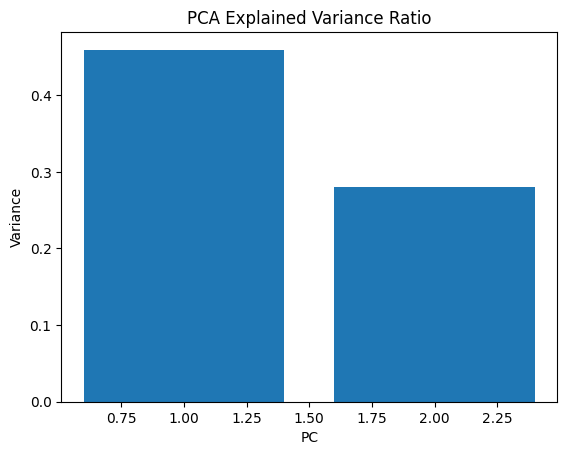

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df_pca = df_encoded.copy()
if target and target in df_pca.columns:
    y = df_pca[target].astype(str).map({"Y":1,"N":0})
    X = df_pca.drop(columns=[target])
else:
    y = None
    X = df_pca

X = X.select_dtypes(include=[np.number]).fillna(0)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure()
plt.bar([1,2], pca.explained_variance_ratio_)
plt.title("PCA Explained Variance Ratio")
plt.xlabel("PC")
plt.ylabel("Variance")
plt.show()
